### Imports

In [34]:
import os
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from math import ceil, floor

### Functions

In [41]:
def create_daily_transfer_plots(data, patAllocOutput, fl_counties, yesVax, vax):
    """
    Create and save individual daily transfer plots.

    Parameters:
    - data (str): Path to the Excel file with patient allocation data (sheet "z").
    - patAllocOutput (str): Directory where the output plots will be saved.
    - fl_counties (GeoDataFrame): GeoDataFrame containing Florida counties geometry.
    - yesVax (bool): If True, use vaccine-specific styling (e.g., blue edges); otherwise, use non-vaccine styling.
    - vax (str): A string identifier (e.g., "Vax0.1" or "NoVax") used in output filenames.
    """
    os.makedirs(patAllocOutput, exist_ok=True)

    # Load and prepare the data
    data = pd.read_excel(data, sheet_name="z")
    data.fillna(0, inplace=True)
    data.columns = ["fromRegion", "toRegion"] + list(data.columns[2:])
    data["fromRegion"] = data["fromRegion"].astype(int)
    data["toRegion"] = data["toRegion"].astype(int)

    # Create a mapping from region ID to county centroid coordinates.
    region_to_pos = {
        idx + 1: (row.geometry.centroid.x, row.geometry.centroid.y)
        for idx, row in fl_counties.iterrows()
    }

    # Loop through each day (columns after the first two) to create individual plots.
    day_columns = data.columns[2:]
    for day in day_columns:
        daily_data = data[["fromRegion", "toRegion", day]].copy()
        daily_data = daily_data[daily_data[day] > 0]  # Only keep transfers with nonzero weight
        if daily_data.empty:
            continue

        # Build a directed graph for the day
        G = nx.DiGraph()
        for _, row in daily_data.iterrows():
            G.add_edge(int(row["fromRegion"]), int(row["toRegion"]), weight=row[day])

        # Create the figure and axes
        fig, ax = plt.subplots(figsize=(10, 10))
        fl_counties.boundary.plot(ax=ax, linewidth=1.5, edgecolor="lightgray")

        # Label each county using its centroid
        for _, row in fl_counties.iterrows():
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, row["NAME"], fontsize=8, ha="center")

        # Use the region-to-position mapping for graph layout
        pos = {region: region_to_pos[region] for region in G.nodes() if region in region_to_pos}

        # Compute normalized edge widths
        weights = nx.get_edge_attributes(G, "weight")
        if weights:
            max_weight = max(weights.values())
            widths = [d["weight"] / max_weight * 5 for _, _, d in G.edges(data=True)]
        else:
            widths = []

        # Choose edge color based on the yesVax flag
        edge_color = "cornflowerblue" if yesVax else "tomato"
        nx.draw_networkx_edges(
            G, pos, ax=ax, arrowstyle="->", arrowsize=10,
            edge_color=edge_color, width=widths
        )

        ax.set_title(f"Patient Transfers on Day {day}", fontsize=24)
        plt.axis("off")

        # Save and close the figure
        plot_path = os.path.join(patAllocOutput, f"travel_day_{day}_{vax}.png")
        plt.savefig(plot_path, bbox_inches="tight")
        plt.close(fig)

    print("Finished saving daily transfer plots.")

def create_stacked_transfer_plot(data, patAllocOutput, fl_counties, yesVax, vax, special_days):
    """
    Create and save a stacked plot (with one subplot per day) for selected days.

    Parameters:
    - data (str): Path to the Excel file with patient allocation data (sheet "z").
    - patAllocOutput (str): Directory where the output plot will be saved.
    - fl_counties (GeoDataFrame): GeoDataFrame containing Florida counties geometry.
    - yesVax (bool): If True, use vaccine-specific styling (e.g., blue edges); otherwise, use non-vaccine styling.
    - vax (str): A string identifier (e.g., "Vax0.1" or "NoVax") used in output filenames.
    - special_days (list of str): List of day column names (as strings) to include in the stacked plot.
    """
    os.makedirs(patAllocOutput, exist_ok=True)

    # Load and prepare the data
    data = pd.read_excel(data, sheet_name="z")
    data.fillna(0, inplace=True)
    data.columns = ["fromRegion", "toRegion"] + list(data.columns[2:])
    data["fromRegion"] = data["fromRegion"].astype(int)
    data["toRegion"] = data["toRegion"].astype(int)

    # Create a mapping from region ID to county centroid coordinates.
    region_to_pos = {
        idx + 1: (row.geometry.centroid.x, row.geometry.centroid.y)
        for idx, row in fl_counties.iterrows()
    }

    # Create one subplot per selected day.
    fig, axes = plt.subplots(nrows=len(special_days), ncols=1,
                             figsize=(15, 22.5), constrained_layout=True)
    # Ensure axes is always iterable
    if len(special_days) == 1:
        axes = [axes]

    for ax, day in zip(axes, special_days):
        daily_data = data[["fromRegion", "toRegion", day]].copy()
        daily_data = daily_data[daily_data[day] > 0]

        # Build the directed graph for the day
        G = nx.DiGraph()
        for _, row in daily_data.iterrows():
            G.add_edge(int(row["fromRegion"]), int(row["toRegion"]), weight=row[day])

        fl_counties.boundary.plot(ax=ax, linewidth=1.5, edgecolor="lightgray")

        # Label each county at its centroid
        for _, row in fl_counties.iterrows():
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, row["NAME"], fontsize=6, ha="center")

        pos = {region: region_to_pos[region] for region in G.nodes() if region in region_to_pos}

        # Calculate normalized edge widths if there are edges
        weights = nx.get_edge_attributes(G, "weight")
        if weights:
            max_weight = max(weights.values())
            widths = [d["weight"] / max_weight * 5 for _, _, d in G.edges(data=True)]
        else:
            widths = []

        edge_color = "cornflowerblue" if yesVax else "tomato"
        nx.draw_networkx_edges(
            G, pos, ax=ax, arrowstyle="->", arrowsize=10,
            edge_color=edge_color, width=widths
        )

        # Place a day label on the left margin
        ax.text(-85.2, 27.5, f"Day {day}", fontsize=14, ha="center", va="center", color="black")
        ax.axis("off")

    # Save and show the stacked plot
    stacked_plot_path = os.path.join(patAllocOutput, f"paperStackedPatientTransfers{vax}.png")
    plt.savefig(stacked_plot_path, dpi=350, bbox_inches="tight")
    #plt.show()

    print(f"Stacked patient allocation plot saved at {stacked_plot_path}.")

def create_individual_heatmaps(data, heatmapOutput, fl_counties, county_order, yesVax, vax):
    """
    Create and save individual heatmaps for each decision period (each column in the 'u' sheet).

    Parameters:
    - data (str): Path to the Excel file containing patient allocation data.
    - heatmapOutput (str): Directory where the heatmap images will be saved.
    - fl_counties (GeoDataFrame): GeoDataFrame of Florida counties.
    - county_order (list): List of county names defining the order.
    - yesVax (bool): If True, uses vaccine-specific styling (Blues) for the heatmap; otherwise uses Reds.
    - vax (str): Identifier string for the vaccine scenario (e.g., "Vax0.1" or "NoVax").
    """
    os.makedirs(heatmapOutput, exist_ok=True)
    
    # Load and prepare the u_data
    u_data = pd.read_excel(data, sheet_name="u")
    u_data.fillna(0, inplace=True)
    # Align u_data index with the county order
    u_data.index = county_order

    # Calculate global min and max for the heatmap color scale
    global_min = u_data.min().min()
    global_max = u_data.max().max()

    # Loop through each decision period (i.e., each column in u_data)
    decision_periods = u_data.columns
    for decision_period in decision_periods:
        # Map the unmet demand values to the counties GeoDataFrame
        fl_counties["UnmetDemand"] = u_data[decision_period].values

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 10))
        cmap = "Blues" if yesVax else "Reds"
        fl_counties.plot(
            column="UnmetDemand",
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor="0.8",
            legend=True,
            legend_kwds={"label": "Unmet Hospital Demand"},
            vmin=global_min,
            vmax=global_max
        )

        # Add county labels at their centroids
        for _, row in fl_counties.iterrows():
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, row["NAME"],
                    fontsize=6, ha="center", color="black")

        ax.set_title(f"Unmet Hospital Demand on Day {decision_period}", fontsize=24)
        ax.axis("off")

        # Save the heatmap image
        output_file = os.path.join(heatmapOutput, f"heatmap_decision_period_{decision_period}_{vax}.png")
        plt.savefig(output_file, dpi=350, bbox_inches="tight")
        plt.close(fig)

    print(f"Heatmaps created for all decision periods in {heatmapOutput}.")

def create_stacked_heatmap(data, heatmapOutput, fl_counties, county_order, yesVax, vax, special_days):
    """
    Create and save a stacked heatmap plot for specified decision periods (special days)
    using a discrete color scheme whose bins are determined dynamically from the data.
    
    Parameters:
    - data (str): Path to the Excel file containing patient allocation data.
    - heatmapOutput (str): Directory where the stacked heatmap image will be saved.
    - fl_counties (GeoDataFrame): GeoDataFrame of Florida counties.
    - county_order (list): List of county names defining the order.
    - yesVax (bool): If True, uses vaccine-specific styling (Blues) for the heatmap; otherwise uses Reds.
    - vax (str): Identifier string for the vaccine scenario (e.g., "Vax0.1" or "NoVax").
    - special_days (list of str): List of decision period labels (e.g., ["30", "90"]) to include in the stacked plot.
    """
    
    os.makedirs(heatmapOutput, exist_ok=True)
    
    # Load and prepare the u_data from the "u" sheet.
    u_data = pd.read_excel(data, sheet_name="u")
    u_data.fillna(0, inplace=True)
    u_data.index = county_order

    # Dynamically determine global min and max across all decision periods.
    global_min = u_data.min().min()
    global_max = u_data.max().max()
    # Create discrete bins spanning the data range (adjust num=5 as needed).
    bins = np.linspace(global_min, global_max, num=5)
    
    # Reindex the counties GeoDataFrame.
    counties = fl_counties.copy().set_index("NAME").reindex(county_order).reset_index()
    
    # Create a discrete colormap and normalization.
    cmap = mpl.cm.Blues if yesVax else mpl.cm.Reds
    norm = mpl.colors.BoundaryNorm(bins, ncolors=cmap.N)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    # Prepare labels for each special day.
    day_labels = [f"Day {day}" for day in special_days]

    # Create subplots (one per special day).
    fig, axes = plt.subplots(nrows=len(special_days), ncols=1,
                             figsize=(15, 22.5), constrained_layout=True)
    if len(special_days) == 1:
        axes = [axes]

    for ax, day, label in zip(axes, special_days, day_labels):
        # Map the unmet demand values for the given day to the counties.
        counties["UnmetDemand"] = u_data[day].values

        # Plot using a user-defined (discrete) classification scheme.
        counties.plot(
            column="UnmetDemand",
            cmap=cmap,
            scheme="UserDefined",
            classification_kwds={"bins": bins},
            linewidth=0.8,
            ax=ax,
            edgecolor="0.8",
            legend=False  # A shared legend (colorbar) will be added below.
        )

        # Add county labels at their centroids.
        for _, row in counties.iterrows():
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, row["NAME"],
                    fontsize=6, ha="center", color="black")

        # Place a label for the day on the left margin.
        ax.text(-85.2, 27.5, label, fontsize=14, ha="center", va="center", color="black")
        ax.axis("off")
    
    # Add a discrete horizontal colorbar below the subplots.
    fig.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.25, 0.0, 0.5, 0.015])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Number of People", fontsize=18)
    cbar.set_ticks(bins)
    cbar.ax.set_xticklabels([f"{ceil(i/1000):.2g}k" for i in bins])
    
    # Save the stacked heatmap image.
    stackedOutput = os.path.join(heatmapOutput, f"paperStackedHeatmap{vax}.png")
    plt.savefig(stackedOutput, dpi=350, bbox_inches="tight")
    plt.close(fig)
    
    print(f"Special heatmap created at {stackedOutput}.")

def create_aggregate_unmet_demand_plot(data, heatmapOutput, fl_counties, county_order, yesVax, vax):
    """
    Create and save a single plot showing the aggregate unmet hospital demand 
    (summed over all decision periods) for Florida counties using a discrete color scheme.
    The bins are determined dynamically from the aggregated data.
    
    Parameters:
    - data (str): Path to the Excel file containing patient allocation data.
    - heatmapOutput (str): Directory where the aggregate heatmap image will be saved.
    - fl_counties (GeoDataFrame): GeoDataFrame of Florida counties.
    - county_order (list): List of county names defining the order (and ensuring alignment).
    - yesVax (bool): If True, use the "Blues" colormap; otherwise, use "Reds".
    - vax (str): Identifier string for the vaccine scenario (e.g., "Vax0.1" or "NoVax").
    """
    os.makedirs(heatmapOutput, exist_ok=True)
    
    # Load and prepare the unmet demand data from the "u" sheet.
    u_data = pd.read_excel(data, sheet_name="u")
    u_data.fillna(0, inplace=True)
    u_data.index = county_order
    
    # Compute aggregate unmet demand for each county (sum across all decision periods).
    agg_demand = u_data.sum(axis=1)
    
    # Reindex the Florida counties GeoDataFrame.
    counties = fl_counties.copy().set_index("NAME").reindex(county_order).reset_index()
    
    # Add the aggregate unmet demand as a new column.
    counties["AggregateUnmetDemand"] = agg_demand.values

    # Dynamically determine the range for the color scale from the aggregated data.
    global_min = agg_demand.min()
    global_max = agg_demand.max()
    bins = np.linspace(global_min, global_max, num=7)
    
    # Create a discrete colormap and normalization.
    cmap = mpl.cm.Blues if yesVax else mpl.cm.Reds
    norm = mpl.colors.BoundaryNorm(bins, ncolors=cmap.N)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    # Create the plot.
    fig, ax = plt.subplots(figsize=(12, 10))
    counties.plot(
        column="AggregateUnmetDemand",
        cmap=cmap,
        scheme="UserDefined",
        classification_kwds={"bins": bins},
        linewidth=0.8,
        ax=ax,
        edgecolor="0.8",
        legend=False  # We'll add one shared legend below
    )
    
    # Add county labels at their centroids.
    for idx, row in counties.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row["NAME"],
                fontsize=6, ha="center", color="black")
    
  
    ax.axis("off")
    
    #ax.set_title("Aggregate Unmet Hospital Demand in Florida\nOver the Entire Time Horizon", fontsize=24)
    #ax.axis("off")
    
    # Add a discrete horizontal colorbar.
    cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.015])  # X, Y, width, height
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Number of People", fontsize=18)

    # Optional: Tweak tick locations & labels if desired
    cbar.set_ticks(bins)
    from math import ceil, floor
    cbar.ax.set_xticklabels([f"{ceil(i/1000):.0f}k" for i in bins])

    
    # Save the aggregate heatmap image.
    output_file = os.path.join(heatmapOutput, f"totalUnmetDemand{vax}.png")
    plt.savefig(output_file, dpi=350, bbox_inches="tight")
    plt.close(fig)
    
    print(f"Aggregate unmet demand plot saved at {output_file}.")


### FL County Spatial Data

In [36]:
# Context code (already provided)
fl_counties = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip")
fl_counties = fl_counties[fl_counties["STATEFP"] == "12"]  # Filter for Florida counties
county_order = [
    "Alachua", "Baker", "Bay", "Bradford", "Brevard", "Broward", "Calhoun", "Charlotte", "Citrus", "Clay",
    "Collier", "Columbia", "DeSoto", "Dixie", "Duval", "Escambia", "Flagler", "Franklin", "Gadsden", "Gilchrist",
    "Glades", "Gulf", "Hamilton", "Hardee", "Hendry", "Hernando", "Highlands", "Hillsborough", "Holmes", 
    "Indian River", "Jackson", "Jefferson", "Lafayette", "Lake", "Lee", "Leon", "Levy", "Liberty", "Madison", 
    "Manatee", "Marion", "Martin", "Miami-Dade", "Monroe", "Nassau", "Okaloosa", "Okeechobee", "Orange", 
    "Osceola", "Palm Beach", "Pasco", "Pinellas", "Polk", "Putnam", "Santa Rosa", "Sarasota", "Seminole", 
    "St. Johns", "St. Lucie", "Sumter", "Suwannee", "Taylor", "Union", "Volusia", "Wakulla", "Walton", "Washington"
]
fl_counties = fl_counties.set_index("NAME").reindex(county_order).reset_index()

### Function Calls

Aggregate unmet demand plot saved at heatmaps\NoVaxResults\totalUnmetDemandNoVax.png.
Finished saving daily transfer plots.
Stacked patient allocation plot saved at allocationPics\NoVaxResults\paperStackedPatientTransfersNoVax.png.
Heatmaps created for all decision periods in heatmaps\NoVaxResults.


C:\Users\alexr\AppData\Local\Temp\ipykernel_32352\1376122216.py:288: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.15)


Special heatmap created at heatmaps\NoVaxResults\paperStackedHeatmapNoVax.png.
Aggregate unmet demand plot saved at heatmaps\NoVaxResults\totalUnmetDemandNoVax.png.


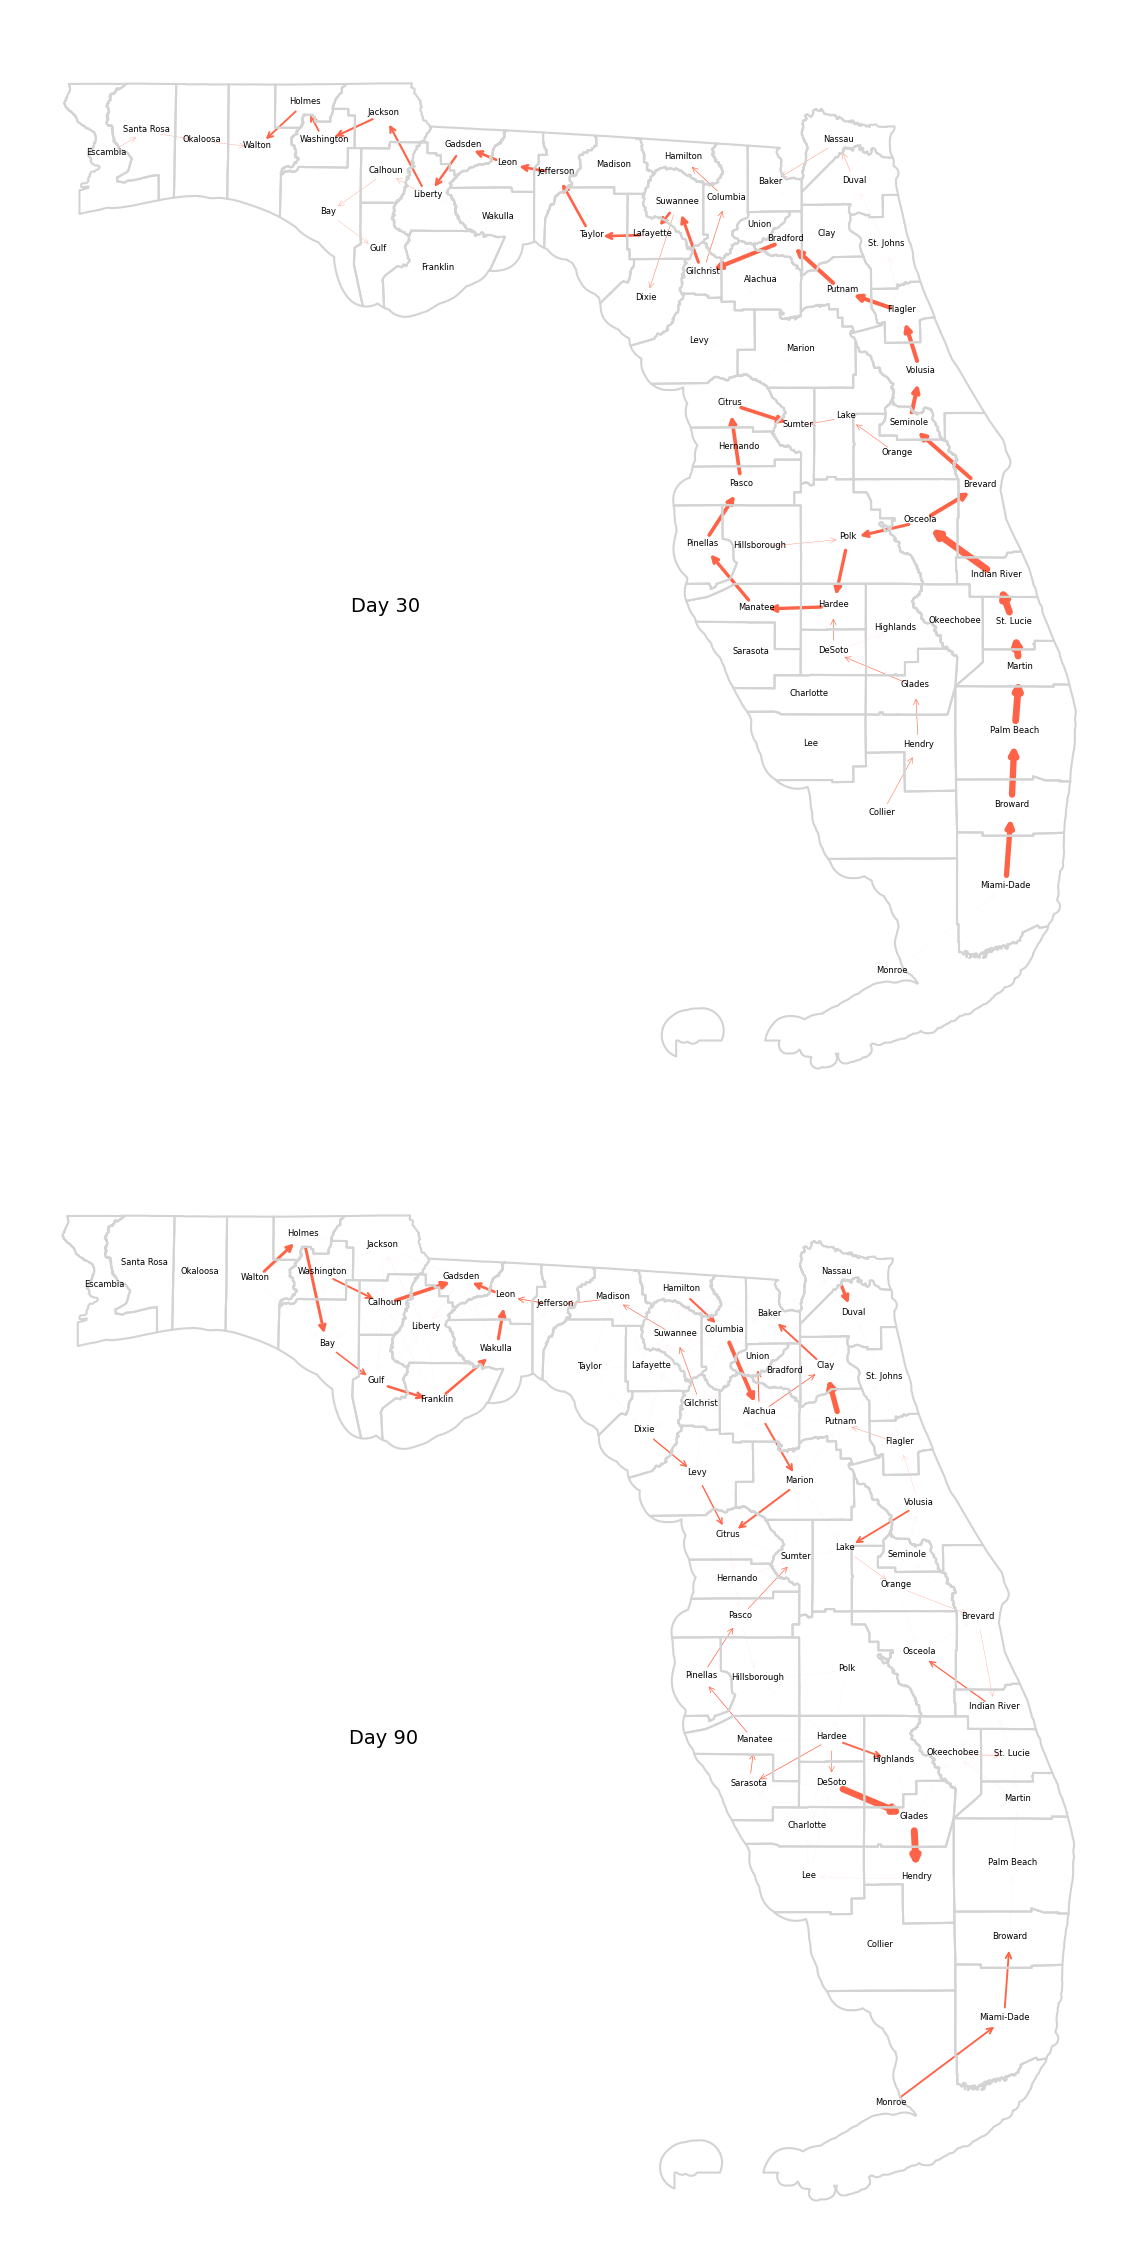

In [42]:
yesVax = False
if yesVax:
    vax = "Vax0.1"
    data = r"outputData\modModelVax0.1.xlsx"
    patAllocOutput = r"allocationPics\Vax0.1Results"
    heatmapOutput = r"heatmaps\Vax0.1Results"
else:
    vax = "NoVax"
    data = r"outputData\modModelNoVax.xlsx"
    patAllocOutput = r"allocationPics\NoVaxResults"
    heatmapOutput = r"heatmaps\NoVaxResults"

# Create individual daily plots
special_days = ["30", "90"]
create_aggregate_unmet_demand_plot(data, heatmapOutput, fl_counties, county_order, yesVax, vax)
create_daily_transfer_plots(data, patAllocOutput, fl_counties, yesVax, vax)
create_stacked_transfer_plot(data, patAllocOutput, fl_counties, yesVax, vax, special_days)
create_individual_heatmaps(data, heatmapOutput, fl_counties, county_order, yesVax, vax)
create_stacked_heatmap(data, heatmapOutput, fl_counties, county_order, yesVax, vax, special_days)
create_aggregate_unmet_demand_plot(data, heatmapOutput, fl_counties, county_order, yesVax, vax)

